In [ ]:
"""
ПЛАТФОРМА A/B-АНАЛИТИКИ: Воспроизводимый пайплайн анализа A/B теста
Работали:
1-6 этап - Нелюбин Роман
7 этап - Микехин Никита
8 этап - Иванов Максим
Датасет: Marketing A/B Testing
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.power import TTestIndPower, NormalIndPower
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import warnings
warnings.filterwarnings('ignore')
# Загрузка данных
import kagglehub
#MAB = kagglehub.dataset_download('faviovaz/marketing-ab-testing', path='marketing_AB.csv ')
#df = pd.read_csv(MAB)
path = kagglehub.dataset_download("faviovaz/marketing-ab-testing")
df =  pd.read_csv('/kaggle/input/marketing-ab-testing/marketing_AB.csv', index_col=0)
#Стили
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


print("ЭТАП 1: Первичный анализ ")
# 1.1 Базовый анализ
print("\n1.1 Базовые статистики:")
print(df.info())
print(f"\nКоличество уникальных значений:")
print(df.nunique())
# 1.2 Анализ пропусков для малого датасета
print("\n1.2 Анализ пропусков:")
missing_data = df.isnull().sum()
if missing_data.sum() == 0:
    print("Пропусков нет")
else:
    missing_percent = (missing_data / len(df)) * 100
    print("ВАЖНО: Пропуски критичны!")
    for col, count in missing_data[missing_data > 0].items():
        print(f"  {col}: {count} пропусков ({missing_percent[col]:.1f}%)")
        if missing_percent[col] > 5:
            print(f"Более 5% пропусков в {col} - может исказить результаты!")

# 1.3 Анализ дубликатов
print("\n1.3 Дубликаты:")
duplicates = df.duplicated().sum()
if duplicates == 0:
    print("Дубликатов нет")
else:
    print(f"Найдено {duplicates} дубликатов ({duplicates/len(df)*100:.1f}%)")
    df = df.drop_duplicates()
    print(f"Дубликаты удалены. Новый размер: {len(df)} записей")
# 1.3 Анализ дубликатов
print("\n1.4 Описательная статистика:")
print(df.describe(include='all'))

Using Colab cache for faster access to the 'marketing-ab-testing' dataset.
ЭТАП 1: Первичный анализ 

1.1 Базовые статистики:
<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB
None

Количество уникальных значений:
user id          588101
test group            2
converted             2
total ads           807
most ads day          7
most ads hour        24
dtype: int64

1.2 Анализ пропусков:
Пропусков нет

1.3 Дубликаты:
Дубликатов нет

1.4 Описательная статистика:
             user id test group converted      total ads most ad

In [ ]:
print("ЭТАП 2: Определение эксперимента и метрик")

# Определение экспериментальных групп
print("\n2.1 Экспериментальные группы:")
print("-"*40)
print("Анализ столбца 'test group':")
print(df['test group'].value_counts())
print(f"\nПропорции:")
print(df['test group'].value_counts(normalize=True).round(3))

print("\n2.2 Определение метрик:")
print("-"*40)
print("""Ппервичная метрика:
• Конверсия (converted): бинарная метрика (1 - конвертировался, 0 - нет)
• Единица рандомизации: пользователь (user id)

Вторичные метрики:
• Общее количество пользователей
• Среднее количество рекламных просмотров (total ads)""")

# Создание четких обозначений групп
df['group'] = df['test group'].map({
    'ad': 'treatment',
    'psa': 'control'
})

print("\n2.3 Переименование групп:")
print("-"*40)
print("ad -> treatment (тестовая группа - с рекламой)")
print("psa -> control (контрольная группа - без рекламы)")
print(f"\nРаспределение после переименования:")
print(df['group'].value_counts())

ЭТАП 2: Определение эксперимента и метрик

2.1 Экспериментальные группы:
----------------------------------------
Анализ столбца 'test group':
test group
ad     564577
psa     23524
Name: count, dtype: int64

Пропорции:
test group
ad     0.96
psa    0.04
Name: proportion, dtype: float64

2.2 Определение метрик:
----------------------------------------
Ппервичная метрика:
• Конверсия (converted): бинарная метрика (1 - конвертировался, 0 - нет)
• Единица рандомизации: пользователь (user id)

Вторичные метрики:
• Общее количество пользователей
• Среднее количество рекламных просмотров (total ads)

2.3 Переименование групп:
----------------------------------------
ad -> treatment (тестовая группа - с рекламой)
psa -> control (контрольная группа - без рекламы)

Распределение после переименования:
group
treatment    564577
control       23524
Name: count, dtype: int64


In [ ]:
print("ЭТАП 3: Валидация дизайна эксперимента")


print("\n3.1 Проверка сбалансированности групп (SRM - SAMPLE RATIO MISMATCH):")

# Ожидаемая пропорция (50/50 для A/B теста)
expected_prop = 0.5
control_count = (df['group'] == 'control').sum()
treatment_count = (df['group'] == 'treatment').sum()
total = len(df)

observed_prop = control_count / total
expected_count = total * expected_prop

print(f"Контрольная группа: {control_count} пользователей ({control_count/total*100:.2f}%)")
print(f"Тестовая группа:   {treatment_count} пользователей ({treatment_count/total*100:.2f}%)")
print(f"Ожидаемая пропорция: 50/50")
print(f"Отклонение от ожидания: {abs(observed_prop - expected_prop)*100:.2f}%")

# Хи-квадрат тест для проверки SRM
observed = [control_count, treatment_count]
expected = [total * expected_prop, total * expected_prop]
chi2_stat, p_value_srm = stats.chisquare(observed, expected)

print(f"\nХи-квадрат тест на SRM:")
print(f"Хи-квадрат статистика: {chi2_stat:.4f}")
print(f"p-value: {p_value_srm:.4f}")

if p_value_srm > 0.05:
    print(" SRM проверка пройдена: группы сбалансированы (p > 0.05)")
else:
    print(" ВНИМАНИЕ: Обнаружен дисбаланс в группах (p < 0.05)")

print("\n3.2 Проверка рандомизации по квадратам:")


# Анализ распределения признаков по группам
covariates = ['total ads', 'most ads day']
for covariate in covariates:
    print(f"\nКовариата: {covariate}")

    if df[covariate].dtype in ['int64', 'float64']:
        # Для числовых t-тест
        control_vals = df[df['group'] == 'control'][covariate]
        treatment_vals = df[df['group'] == 'treatment'][covariate]

        t_stat, p_val = stats.ttest_ind(control_vals, treatment_vals, equal_var=False)

        print(f" Контроль: mean={control_vals.mean():.2f}, std={control_vals.std():.2f}")
        print(f" Тест:     mean={treatment_vals.mean():.2f}, std={treatment_vals.std():.2f}")
        print(f" t-статистика: {t_stat:.4f}, p-value: {p_val:.4f}")

        if p_val > 0.05:
            print(" Баланс соблюден (p > 0.05)")
        else:
            print(" Возможна проблема с рандомизацией (p < 0.05)")

    else:
        # Для категориальных переменных используем хи-квадрат
        contingency = pd.crosstab(df[covariate], df['group'])
        chi2, p_val, dof, expected = chi2_contingency(contingency)

        print(f" Распределение по группам:")
        print(contingency)
        print(f" Хи-квадрат: {chi2:.4f}, p-value: {p_val:.4f}")

        if p_val > 0.05:
            print(" Баланс соблюден (p > 0.05)")
        else:
            print(" Возможна проблема с рандомизацией (p < 0.05)")


ЭТАП 3: Валидация дизайна эксперимента

3.1 Проверка сбалансированности групп (SRM - SAMPLE RATIO MISMATCH):
Контрольная группа: 23524 пользователей (4.00%)
Тестовая группа:   564577 пользователей (96.00%)
Ожидаемая пропорция: 50/50
Отклонение от ожидания: 46.00%

Хи-квадрат тест на SRM:
Хи-квадрат статистика: 497768.8336
p-value: 0.0000
 ВНИМАНИЕ: Обнаружен дисбаланс в группах (p < 0.05)

3.2 Проверка рандомизации по квадратам:

Ковариата: total ads
 Контроль: mean=24.76, std=42.86
 Тест:     mean=24.82, std=43.75
 t-статистика: -0.2180, p-value: 0.8274
 Баланс соблюден (p > 0.05)

Ковариата: most ads day
 Распределение по группам:
group         control  treatment
most ads day                    
Friday           3803      88805
Monday           3502      83571
Saturday         2858      78802
Sunday           3059      82332
Thursday         3905      79077
Tuesday          2907      74572
Wednesday        3490      77418
 Хи-квадрат: 235.6145, p-value: 0.0000
 Возможна проблема с ра

ЭТАП 4: Очистка данных и подготовка

4.1 Фильтрация пользователей:
Всего записей: 588101
Уникальных user id: 588101
 Каждый пользователь встречается только один раз

4.2 Анализ и обработка выбросов:
Найдены числовые столбцы: ['user id', 'total ads', 'most ads hour']

user id:
  Q1=1143190.00, Q3=1484088.00, IQR=340898.00
  Границы выбросов: [631843.00, 1995435.00]
  Выбросов: 0 (0.00%)
 Выбросов в допустимых пределах

total ads:
  Q1=4.00, Q3=27.00, IQR=23.00
  Границы выбросов: [-30.50, 61.50]
  Выбросов: 52057 (8.85%)
 Много выбросов (8.9%) - winsorization
 Применено winsorization (1%-99%)
  Статистика после winsorization:
    Min: 1.00
    Max: 202.00
    Mean: 23.59
    Std: 33.16

most ads hour:
  Q1=11.00, Q3=18.00, IQR=7.00
  Границы выбросов: [0.50, 28.50]
  Выбросов: 5536 (0.94%)
 Выбросов в допустимых пределах

4.3 Анализ категориальных переменных:
Категориальные столбцы: ['test group', 'most ads day', 'group']

test group:
  Уникальных значений: 2
  Распределение:
    ad: 56

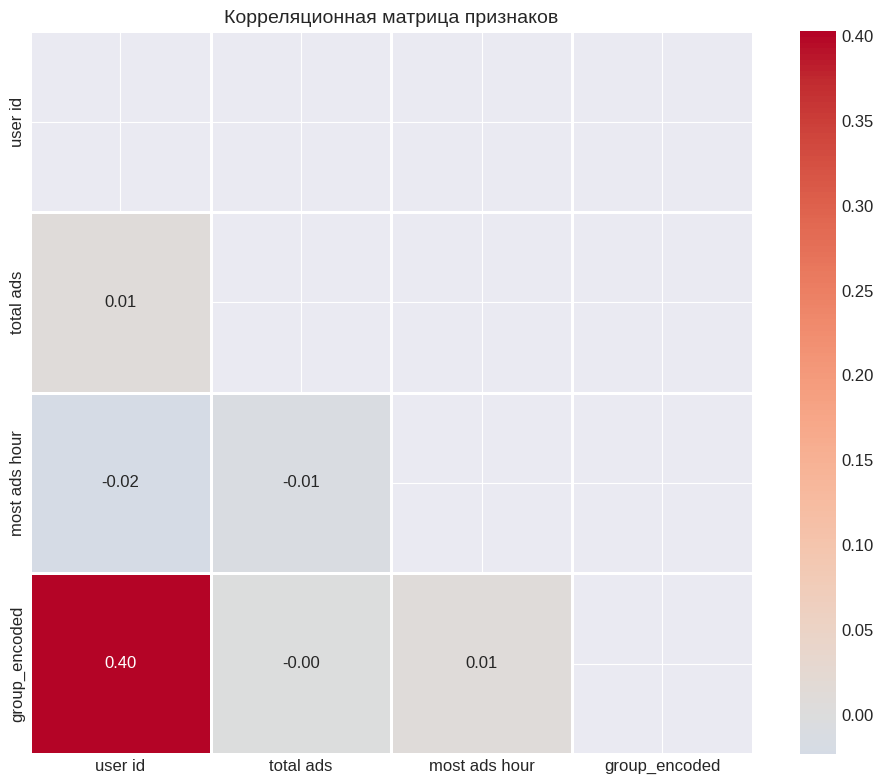


4.6 Итоговый набор данных:
----------------------------------------
Размер очищенного датасета: (588101, 7)
Контрольная группа: 23524 пользователей
Тестовая группа: 564577 пользователей

Пропорции после очистки:
  Контроль: 4.00%
  Тест: 96.00%
 Пропорции групп сохранились после очистки

4.7 Сохранение очищенных данных:
----------------------------------------
 Очищенные данные сохранены в файл: marketing_ab_clean.csv

Сводная статистика по группам после очистки:


,n_users,conversions,conversion_rate,avg_total_ads,std_total_ads,min_total_ads,max_total_ads
group,,,,,,,
control,23524,420,0.018,23.654,34.491,1.0,202.0
treatment,564577,14423,0.026,23.589,33.108,1.0,202.0


In [ ]:
print("ЭТАП 4: Очистка данных и подготовка")

df_clean = df.copy()

print("\n4.1 Фильтрация пользователей:")

# Проверка уникальности пользователей
print(f"Всего записей: {len(df_clean)}")
print(f"Уникальных user id: {df_clean['user id'].nunique()}")

if len(df_clean) == df_clean['user id'].nunique():
    print(" Каждый пользователь встречается только один раз")
else:
    print(" Есть повторяющиеся user id")
    # Удаление дубликатов по user id, оставляя первую запись
    df_clean = df_clean.drop_duplicates(subset=['user id'])
    print(f" Оставлено {len(df_clean)} уникальных пользователей")

print("\n4.2 Анализ и обработка выбросов:")

# Анализ выбросов только в существующих числовых столбцах
# Проверка на числовые столбцы
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print(f"Найдены числовые столбцы: {numeric_cols}")

# Исключаем бинарные столбцы (converted) из анализа выбросов
numeric_cols = [col for col in numeric_cols if df_clean[col].nunique() > 2]

for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    outliers_pct = len(outliers) / len(df_clean) * 100

    print(f"\n{col}:")
    print(f"  Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}")
    print(f"  Границы выбросов: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Выбросов: {len(outliers)} ({outliers_pct:.2f}%)")

    if outliers_pct > 5:
        print(f" Много выбросов ({outliers_pct:.1f}%) - winsorization")
        # Winsorization (ограничение выбросов)
        lower_limit = df_clean[col].quantile(0.01)
        upper_limit = df_clean[col].quantile(0.99)
        df_clean[col] = np.where(df_clean[col] < lower_limit, lower_limit,
                                 np.where(df_clean[col] > upper_limit, upper_limit, df_clean[col]))
        print(f" Применено winsorization (1%-99%)")

        # Обновляем статистику после winsorization
        print(f"  Статистика после winsorization:")
        print(f"    Min: {df_clean[col].min():.2f}")
        print(f"    Max: {df_clean[col].max():.2f}")
        print(f"    Mean: {df_clean[col].mean():.2f}")
        print(f"    Std: {df_clean[col].std():.2f}")
    else:
        print(f" Выбросов в допустимых пределах")

print("\n4.3 Анализ категориальных переменных:")


# Анализ категориальных переменных
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальные столбцы: {categorical_cols}")

for col in categorical_cols:
    if col != 'user id':  # Исключение идентификаторов
        print(f"\n{col}:")
        value_counts = df_clean[col].value_counts()
        print(f"  Уникальных значений: {df_clean[col].nunique()}")
        print(f"  Распределение:")
        for value, count in value_counts.head().items():
            percentage = count / len(df_clean) * 100
            print(f"    {value}: {count} ({percentage:.1f}%)")

        # Проверка на доминирующие категории
        if len(value_counts) > 0:
            top_category_pct = value_counts.iloc[0] / len(df_clean) * 100
            if top_category_pct > 80:
                print(f" Внимание: одна категория составляет {top_category_pct:.1f}% данных")

print("\n4.4 Анализ бинарной переменной (converted):")

# Анализ целевой переменной
conversion_rate = df_clean['converted'].mean() * 100
print(f"Общая конверсия: {conversion_rate:.2f}%")
print(f"Конверсия по группам:")
conversion_by_group = df_clean.groupby('group')['converted'].mean() * 100
print(conversion_by_group)

# Проверка баланса конверсии
if conversion_rate < 1:
    print(f" Внимание: очень низкая общая конверсия ({conversion_rate:.2f}%)")
    print("  Это может потребовать больших выборок для обнаружения эффекта")

print("\n4.5 Проверка корелляции между признаками:")

# Создание числовых переменных для корреляционного анализа
df_numeric = df_clean.copy()

# Кодирование категориальных переменных для корреляционного анализа
if 'most ads day' in df_numeric.columns:
    # One-hot encoding для дня недели
    day_dummies = pd.get_dummies(df_numeric['most ads day'], prefix='day', drop_first=True)
    df_numeric = pd.concat([df_numeric, day_dummies], axis=1)
    df_numeric = df_numeric.drop('most ads day', axis=1)

# Кодирование группы
df_numeric['group_encoded'] = df_numeric['group'].map({'control': 0, 'treatment': 1})

# Удаление нечисловых столбцов
df_numeric = df_numeric.select_dtypes(include=[np.number])

# Рассчитывание корреляции
correlation_matrix = df_numeric.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Корреляционная матрица признаков', fontsize=14)
plt.tight_layout()
plt.show()

# Анализ корреляций с целевой переменной (converted)
if 'converted' in correlation_matrix.columns:
    correlations_with_target = correlation_matrix['converted'].sort_values(ascending=False)
    print("\nКорреляции с целевой переменной (converted):")
    for feature, corr in correlations_with_target.items():
        if feature != 'converted' and abs(corr) > 0.1:
            print(f"  {feature}: {corr:.3f}")

print("\n4.6 Итоговый набор данных:")
print("-"*40)
print(f"Размер очищенного датасета: {df_clean.shape}")
print(f"Контрольная группа: {(df_clean['group'] == 'control').sum()} пользователей")
print(f"Тестовая группа: {(df_clean['group'] == 'treatment').sum()} пользователей")
print(f"\nПропорции после очистки:")
print(f"  Контроль: {(df_clean['group'] == 'control').sum()/len(df_clean)*100:.2f}%")
print(f"  Тест: {(df_clean['group'] == 'treatment').sum()/len(df_clean)*100:.2f}%")

# Проверка, что пропорции групп не изменились кардинально
original_prop_control = (df['test group'] == 'psa').sum() / len(df)
new_prop_control = (df_clean['group'] == 'control').sum() / len(df_clean)

if abs(original_prop_control - new_prop_control) < 0.01:
    print(" Пропорции групп сохранились после очистки")
else:
    print(f" Пропорции групп немного изменились: с {original_prop_control:.3f} до {new_prop_control:.3f}")

print("\n4.7 Сохранение очищенных данных:")
print("-"*40)

# Сохранение очищенного датасета для дальнейшего анализа
df_clean.to_csv('marketing_ab_clean.csv', index=False)
print(" Очищенные данные сохранены в файл: marketing_ab_clean.csv")

# Создание сводной таблицы по группам для быстрого анализа
summary_stats = df_clean.groupby('group').agg({
    'user id': 'count',
    'converted': ['sum', 'mean'],
    'total ads': ['mean', 'std', 'min', 'max']
}).round(3)

summary_stats.columns = ['n_users', 'conversions', 'conversion_rate',
                         'avg_total_ads', 'std_total_ads', 'min_total_ads', 'max_total_ads']
print("\nСводная статистика по группам после очистки:")
display(summary_stats)

In [ ]:
print("ЭТАП 5: Статистический анализ метрик")

# Создание агрегированных данных по группам
group_stats = df_clean.groupby('group').agg({
    'user id': 'count',
    'converted': ['sum', 'mean'],
    'total ads': 'mean'
}).round(4)

group_stats.columns = ['n_users', 'conversions', 'conversion_rate', 'avg_total_ads']
group_stats = group_stats.reset_index()

print("\n5.1 Ооснование метрик по группам:")
display(group_stats)
print("\n5.2 Статистические тесты конверсии:")


# Подготовка данных для z-теста пропорций
control_converted = group_stats.loc[group_stats['group'] == 'control', 'conversions'].values[0]
control_total = group_stats.loc[group_stats['group'] == 'control', 'n_users'].values[0]
treatment_converted = group_stats.loc[group_stats['group'] == 'treatment', 'conversions'].values[0]
treatment_total = group_stats.loc[group_stats['group'] == 'treatment', 'n_users'].values[0]

print(f"Контроль: {control_converted}/{control_total} = {control_converted/control_total*100:.2f}%")
print(f"Тест:     {treatment_converted}/{treatment_total} = {treatment_converted/treatment_total*100:.2f}%")

# Z-тест для пропорций
successes = [control_converted, treatment_converted]
nobs = [control_total, treatment_total]
z_stat, p_value = proportions_ztest(successes, nobs, alternative='two-sided')

print(f"\nZ-тест для разницы пропорций:")
print(f"Z-статистика: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Расчет доверительного интервала для разницы пропорций
ci = confint_proportions_2indep(treatment_converted, treatment_total,
                                control_converted, control_total,
                                method='wald', compare='diff')
print(f"95% ДИ для разницы пропорций (тест - контроль): [{ci[0]:.4f}, {ci[1]:.4f}]")

# Расчет относительного изменения (lift)
control_rate = control_converted / control_total
treatment_rate = treatment_converted / treatment_total
absolute_diff = treatment_rate - control_rate
relative_diff = absolute_diff / control_rate * 100 if control_rate > 0 else 0

print(f"\nАбсолютная разница: {absolute_diff:.4f}")
print(f"Относительное изменение (lift): {relative_diff:.2f}%")

print("\n5.3 Тесты для количественных метрик:")




# T-тест для total ads
control_ads = df_clean[df_clean['group'] == 'control']['total ads']
treatment_ads = df_clean[df_clean['group'] == 'treatment']['total ads']

t_stat_ads, p_val_ads = stats.ttest_ind(control_ads, treatment_ads, equal_var=False)
print(f"\nМетрика: total ads")

print(f"Контроль: mean={control_ads.mean():.2f}, std={control_ads.std():.2f}")
print(f"Тест:     mean={treatment_ads.mean():.2f}, std={treatment_ads.std():.2f}")
print(f"t-статистика: {t_stat_ads:.4f}, p-value: {p_val_ads:.4f}")

# Bootstrap для доверительного интервала разницы средних
def bootstrap_diff_ci(data1, data2, n_bootstrap=10000, ci=95):
    diffs = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        diffs.append(sample2.mean() - sample1.mean())

    lower = np.percentile(diffs, (100 - ci) / 2)
    upper = np.percentile(diffs, ci + (100 - ci) / 2)
    return lower, upper

ci_ads = bootstrap_diff_ci(control_ads.values, treatment_ads.values)
print(f"95% ДИ для разницы средних (bootstrap): [{ci_ads[0]:.4f}, {ci_ads[1]:.4f}]")
print("\n5.4 Оценка мощности теста и MDE:")

# Расчет достигнутой мощности
power_analysis = TTestIndPower()

effect_size = absolute_diff / np.sqrt(control_rate * (1 - control_rate) + treatment_rate * (1 - treatment_rate))
achieved_power = power_analysis.power(effect_size=effect_size,
                                      nobs1=control_total,
                                      alpha=0.05,
                                      ratio=treatment_total/control_total)

# Расчет MDE (Minimum Detectable Effect)
mde = power_analysis.solve_power(effect_size=None,
                                power=0.8,
                                nobs1=control_total,
                                alpha=0.05,
                                ratio=treatment_total/control_total)

print(f"Размер эффекта (Cohen's d): {effect_size:.4f}")
print(f"Достигнутая мощность теста: {achieved_power:.2%}")
print(f"MDE при мощности 80%: {mde:.4f} (абсолютное изменение)")

ЭТАП 5: Статистический анализ метрик

5.1 Ооснование метрик по группам:


,group,n_users,conversions,conversion_rate,avg_total_ads
0,control,23524,420,0.0179,23.6540
1,treatment,564577,14423,0.0255,23.5885



5.2 Статистические тесты конверсии:
Контроль: 420/23524 = 1.79%
Тест:     14423/564577 = 2.55%

Z-тест для разницы пропорций:
Z-статистика: -7.3701
p-value: 0.0000
95% ДИ для разницы пропорций (тест - контроль): [0.0060, 0.0094]

Абсолютная разница: 0.0077
Относительное изменение (lift): 43.09%

5.3 Тесты для количественных метрик:

Метрика: total ads
Контроль: mean=23.65, std=34.49
Тест:     mean=23.59, std=33.11
t-статистика: 0.2857, p-value: 0.7751
95% ДИ для разницы средних (bootstrap): [-0.5133, 0.3876]

5.4 Оценка мощности теста и MDE:
Размер эффекта (Cohen's d): 0.0373
Достигнутая мощность теста: 99.99%
MDE при мощности 80%: 0.0186 (абсолютное изменение)


ЭТАП 6: Стратификационный анализ

6.1 Анализ по дням недели (most ads day):
Конверсия по дням недели и группам:


,most ads day,group,n_users,conversion_rate
0,Friday,control,3803,0.0163
1,Friday,treatment,88805,0.0225
2,Monday,control,3502,0.0226
3,Monday,treatment,83571,0.0332
4,Saturday,control,2858,0.0140
5,Saturday,treatment,78802,0.0213
6,Sunday,control,3059,0.0206
7,Sunday,treatment,82332,0.0246
8,Thursday,control,3905,0.0202
9,Thursday,treatment,79077,0.0216


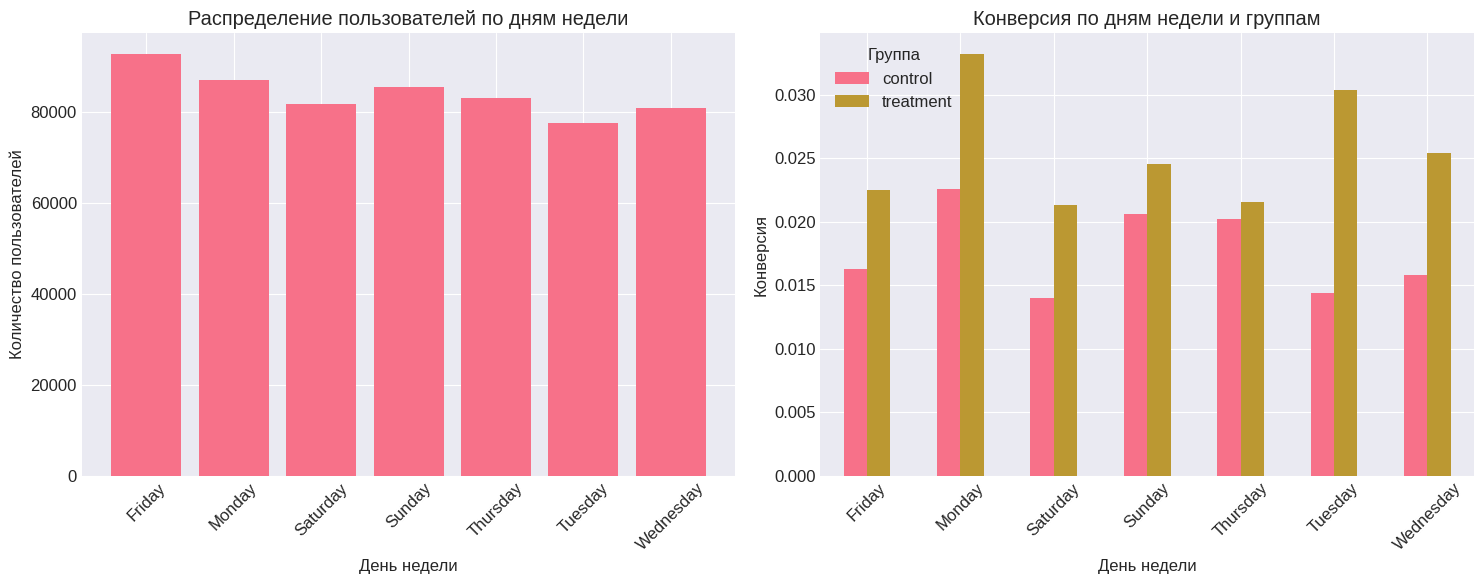


6.2 Анализ по количеству рекламы:
Конверсия по категориям показов и группам:


,ads_category,group,n_users,conversion_rate
0,0-5,control,7861,0.0028
1,0-5,treatment,169962,0.0025
2,6-10,control,3415,0.0067
3,6-10,treatment,79537,0.0049
4,11-20,control,4150,0.0082
5,11-20,treatment,123334,0.0084
6,21-50,control,5235,0.0218
7,21-50,treatment,125541,0.0292
8,51-100,control,1853,0.0577
9,51-100,treatment,44149,0.1163


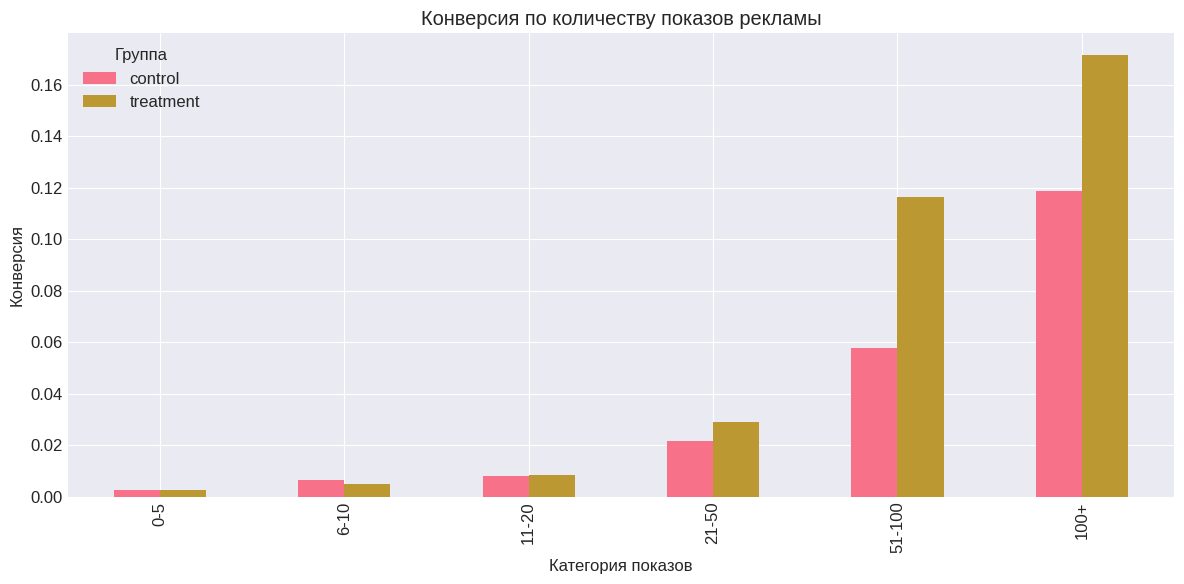

In [ ]:
print("ЭТАП 6: Стратификационный анализ")
print("\n6.1 Анализ по дням недели (most ads day):")

# Анализ конверсии по дням недели
if 'most ads day' in df_clean.columns:
    day_conversion = df_clean.groupby(['most ads day', 'group']).agg({
        'user id': 'count',
        'converted': 'mean'
    }).round(4)

    day_conversion = day_conversion.rename(columns={'user id': 'n_users', 'converted': 'conversion_rate'})
    day_conversion = day_conversion.reset_index()

    print("Конверсия по дням недели и группам:")
    display(day_conversion)

    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Распределение по дням
    day_counts = df_clean['most ads day'].value_counts().sort_index()
    axes[0].bar(day_counts.index, day_counts.values)
    axes[0].set_title('Распределение пользователей по дням недели')
    axes[0].set_xlabel('День недели')
    axes[0].set_ylabel('Количество пользователей')
    axes[0].tick_params(axis='x', rotation=45)

    # Конверсия по дням и группам
    pivot_data = day_conversion.pivot(index='most ads day', columns='group', values='conversion_rate')
    pivot_data.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Конверсия по дням недели и группам')
    axes[1].set_xlabel('День недели')
    axes[1].set_ylabel('Конверсия')
    axes[1].legend(title='Группа')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

print("\n6.2 Анализ по количеству рекламы:")

# Создание категорий по количеству показов
df_clean['ads_category'] = pd.cut(df_clean['total ads'],
                                 bins=[0, 5, 10, 20, 50, 100, df_clean['total ads'].max()],
                                 labels=['0-5', '6-10', '11-20', '21-50', '51-100', '100+'])

ads_conversion = df_clean.groupby(['ads_category', 'group']).agg({
    'user id': 'count',
    'converted': 'mean'
}).round(4)

ads_conversion = ads_conversion.rename(columns={'user id': 'n_users', 'converted': 'conversion_rate'})
ads_conversion = ads_conversion.reset_index()

print("Конверсия по категориям показов и группам:")
display(ads_conversion)

# Визуализация
fig, ax = plt.subplots(figsize=(12, 6))
ads_pivot = ads_conversion.pivot(index='ads_category', columns='group', values='conversion_rate')
ads_pivot.plot(kind='bar', ax=ax)
ax.set_title('Конверсия по количеству показов рекламы')
ax.set_xlabel('Категория показов')
ax.set_ylabel('Конверсия')
ax.legend(title='Группа')
plt.tight_layout()
plt.show()

ЭТАП 7: Визуализация и графики


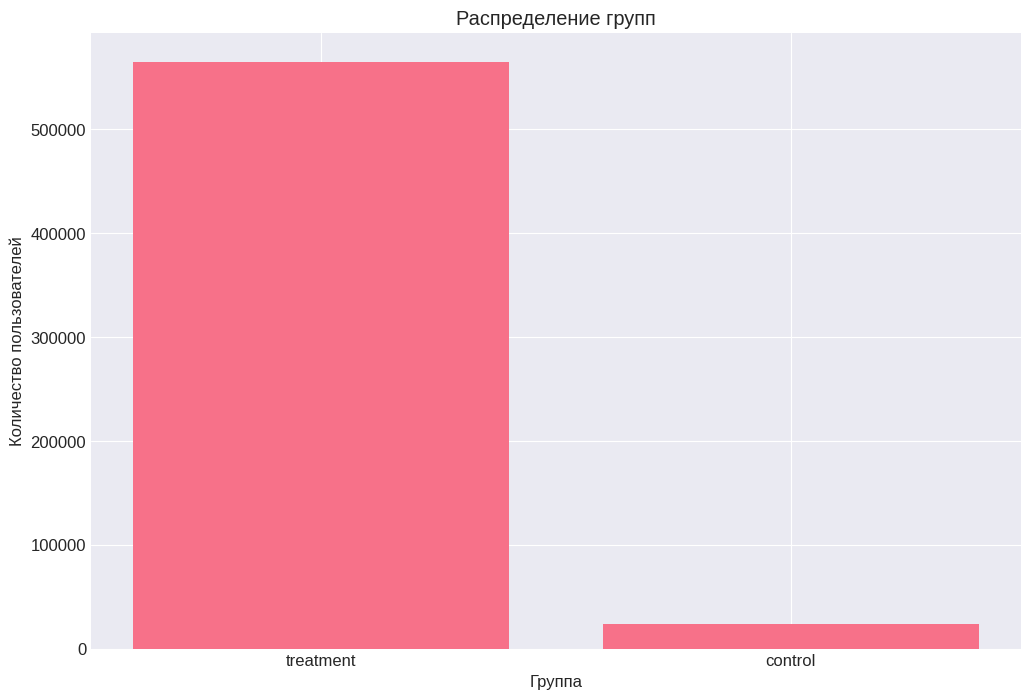

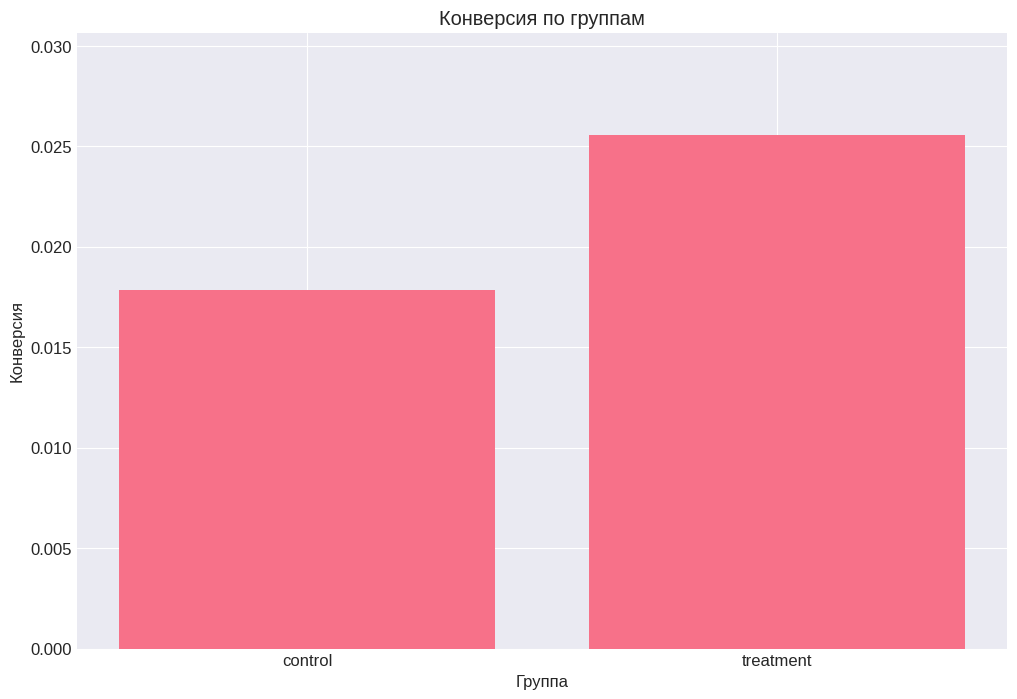

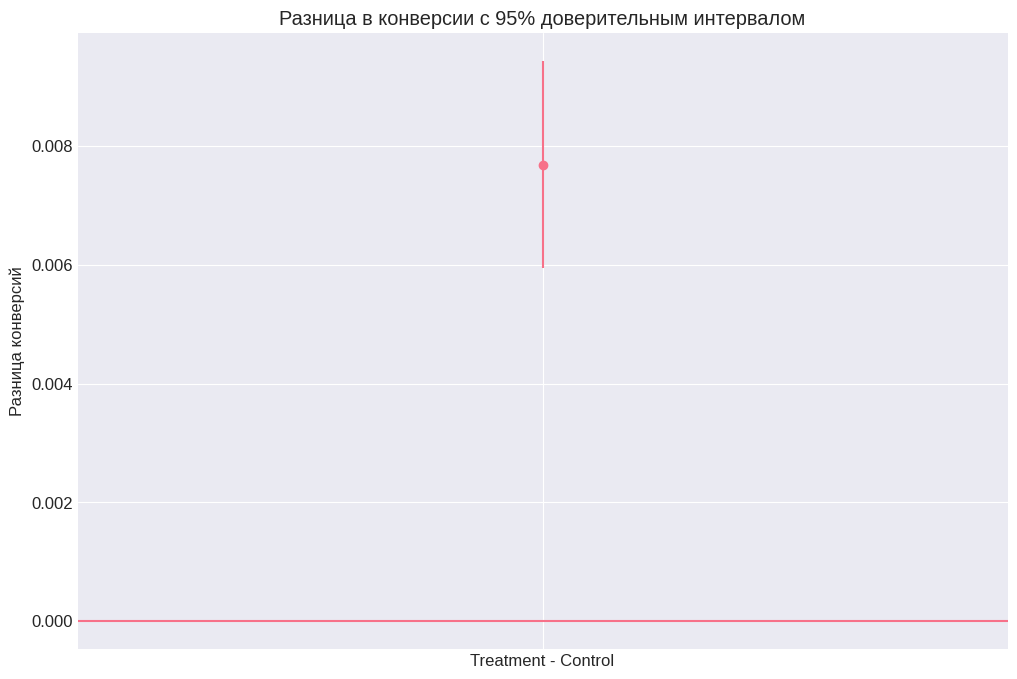

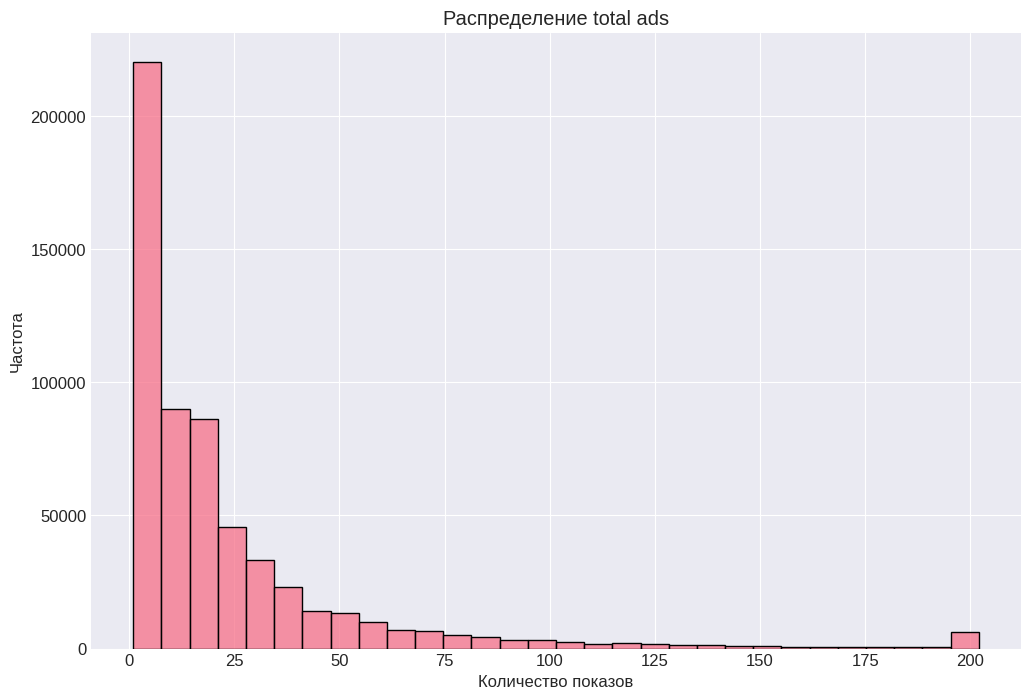

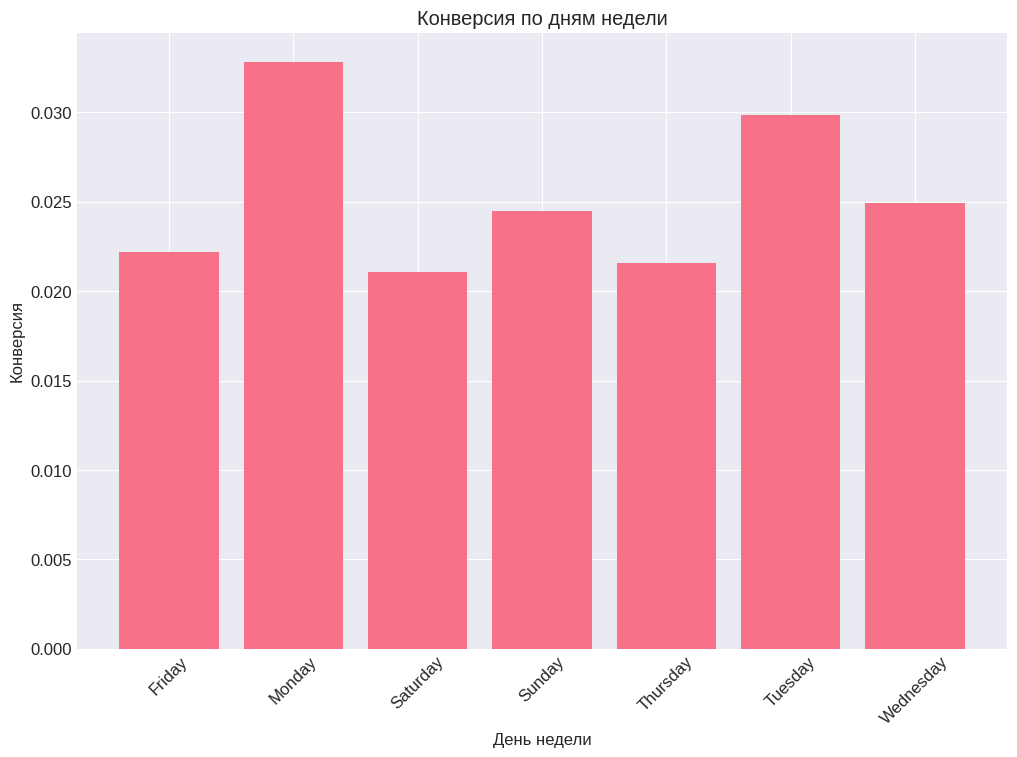

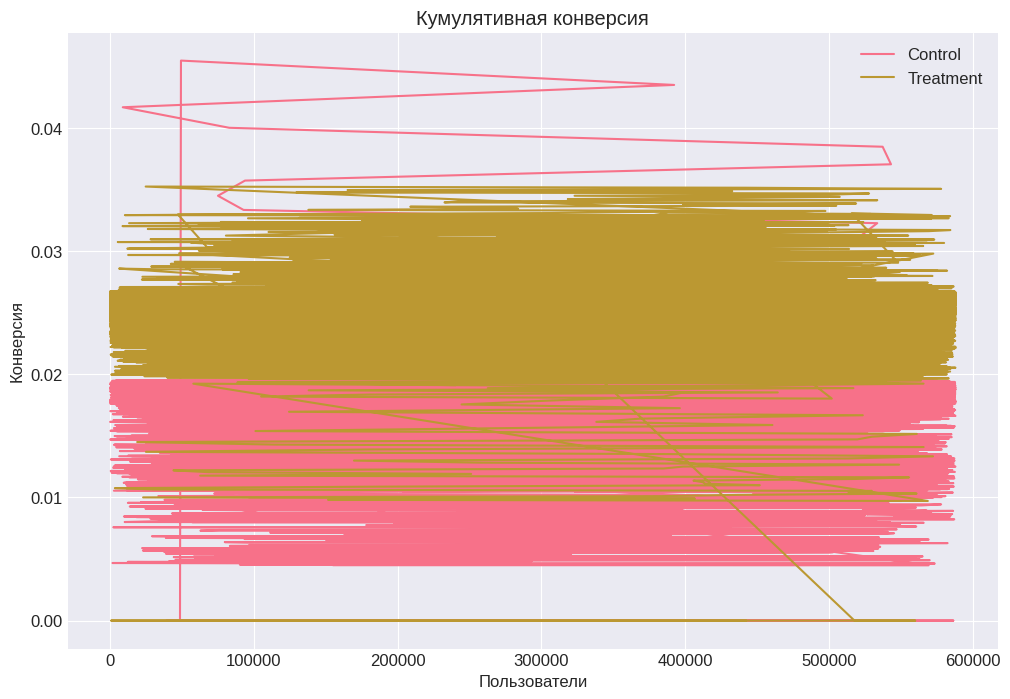

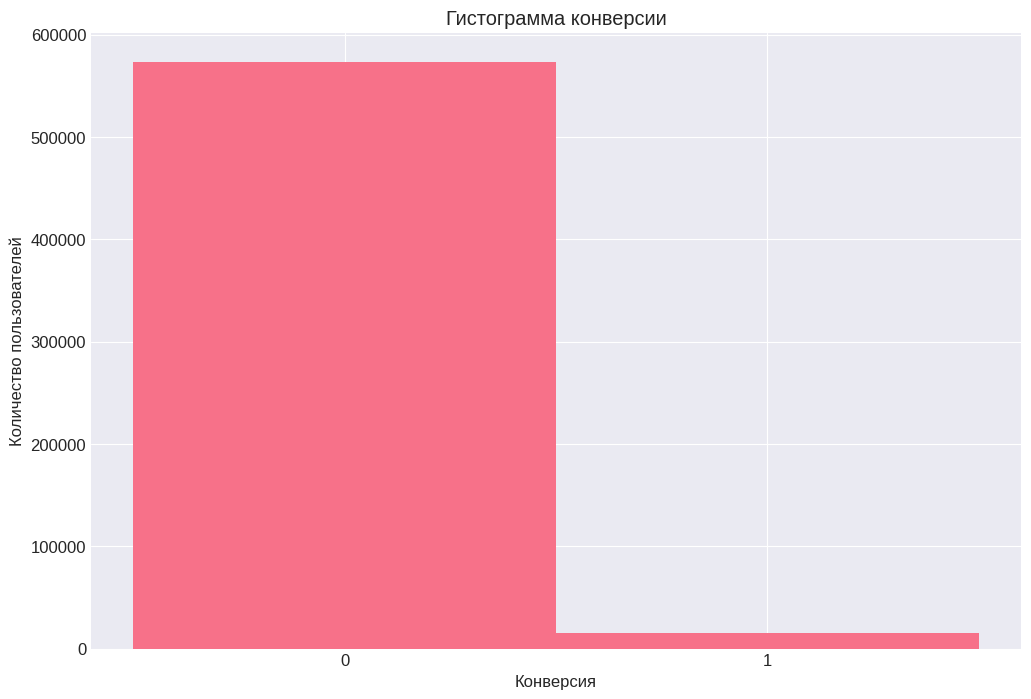

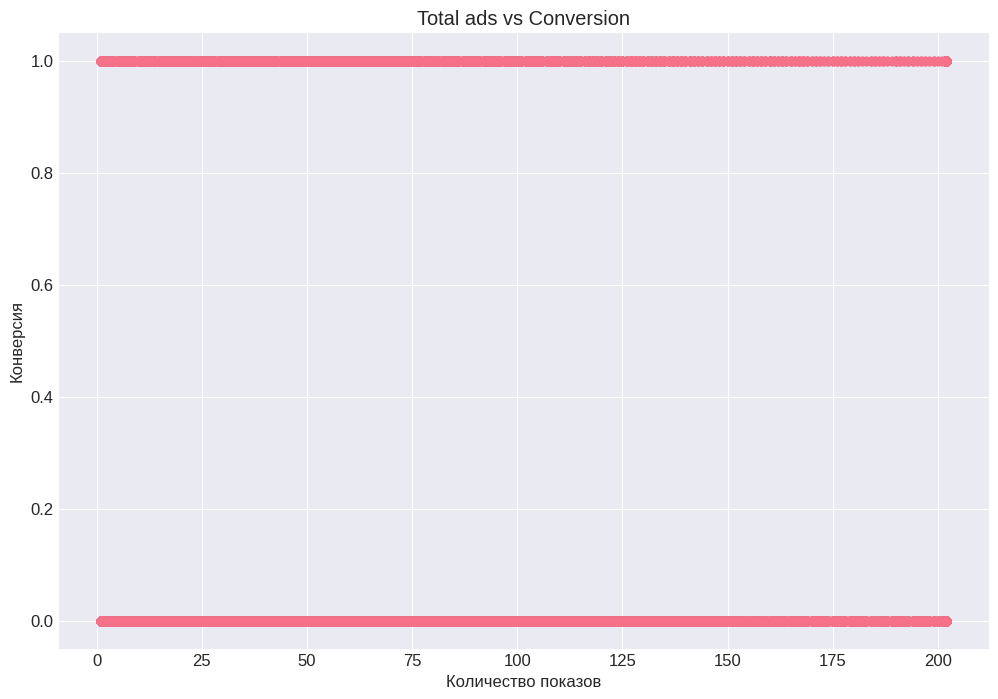

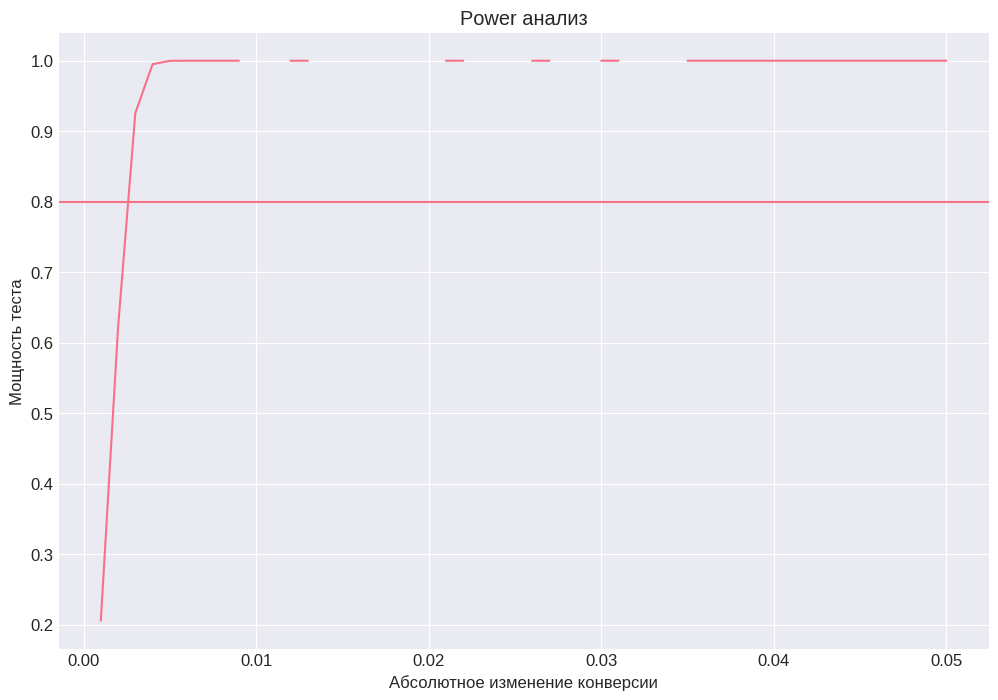

In [ ]:
print("ЭТАП 7: Визуализация и графики")

# Распределение групп
plt.figure()
group_counts = df_clean['group'].value_counts()
plt.bar(group_counts.index, group_counts.values)
plt.title('Распределение групп')
plt.ylabel('Количество пользователей')
plt.xlabel('Группа')
plt.show()
# Конверсия по группам
plt.figure()
conversion_by_group = df_clean.groupby('group')['converted'].mean()
plt.bar(conversion_by_group.index, conversion_by_group.values)
plt.title('Конверсия по группам')
plt.ylabel('Конверсия')
plt.xlabel('Группа')
plt.ylim(0, conversion_by_group.max() * 1.2)
plt.show()
# Разница в конверсии с доверительным интервалом
diff = treatment_rate - control_rate
ci_low, ci_high = ci

plt.figure()
plt.errorbar(
    x=['Treatment - Control'],
    y=[diff],
    yerr=[[diff - ci_low], [ci_high - diff]],
    fmt='o'
)
plt.axhline(0)
plt.title('Разница в конверсии с 95% доверительным интервалом')
plt.ylabel('Разница конверсий')
plt.show()
# Распределение total ads
plt.figure()
sns.histplot(df_clean['total ads'], bins=30)
plt.title('Распределение total ads')
plt.xlabel('Количество показов')
plt.ylabel('Частота')
plt.show()
# Распределение conversion по дням
plt.figure()
day_conv = df_clean.groupby('most ads day')['converted'].mean()
plt.bar(day_conv.index, day_conv.values)
plt.title('Конверсия по дням недели')
plt.xlabel('День недели')
plt.ylabel('Конверсия')
plt.xticks(rotation=45)
plt.show()
# Кумулятивная конверсия
df_sorted = df_clean.sort_values('user id')

df_sorted['cum_conv_control'] = (
    df_sorted[df_sorted['group'] == 'control']['converted']
    .expanding()
    .mean()
)

df_sorted['cum_conv_treatment'] = (
    df_sorted[df_sorted['group'] == 'treatment']['converted']
    .expanding()
    .mean()
)

plt.figure()
plt.plot(df_sorted['cum_conv_control'], label='Control')
plt.plot(df_sorted['cum_conv_treatment'], label='Treatment')
plt.title('Кумулятивная конверсия')
plt.xlabel('Пользователи')
plt.ylabel('Конверсия')
plt.legend()
plt.show()
# Гистограмма конверсии
plt.figure()
plt.hist(df_clean['converted'].astype(int), bins=[-0.5, 0.5, 1.5])
plt.title('Гистограмма конверсии')
plt.xlabel('Конверсия')
plt.ylabel('Количество пользователей')
plt.xticks([0, 1])
plt.show()
# Scatter plot: total ads vs conversion
plt.figure()
plt.scatter(df_clean['total ads'], df_clean['converted'], alpha=0.3)
plt.title('Total ads vs Conversion')
plt.xlabel('Количество показов')
plt.ylabel('Конверсия')
plt.show()
# Power анализ
effect_sizes = np.linspace(0.001, 0.05, 50)
powers = [
    power_analysis.power(
        effect_size=es / np.sqrt(control_rate * (1 - control_rate)),
        nobs1=control_total,
        alpha=0.05,
        ratio=treatment_total / control_total
    )
    for es in effect_sizes
]

plt.figure()
plt.plot(effect_sizes, powers)
plt.axhline(0.8)
plt.title('Power анализ')
plt.xlabel('Абсолютное изменение конверсии')
plt.ylabel('Мощность теста')
plt.show()

In [ ]:
print("ЭТАП 8: Итоговый отчёт\n" + "="*80)

# =============================================================================
# 8.1 Ключевые характеристики эксперимента
# =============================================================================
print("\n8.1 Основные характеристики эксперимента")
print("-"*70)
total_users = len(df)
control_users = len(df[df['group'] == 'control'])
treatment_users = len(df[df['group'] == 'treatment'])

print(f"Общий размер выборки:          {total_users:,} пользователей")
print(f"Контрольная группа (psa):      {control_users:,} ({control_users/total_users*100:.2f}%)")
print(f"Тестовая группа (ad):          {treatment_users:,} ({treatment_users/total_users*100:.2f}%)")
print("→ Очень сильный дисбаланс (96/4). Это не классический A/B-тест → выводы требуют осторожности.")

# =============================================================================
# 8.2 Первичная метрика — Конверсия
# =============================================================================
print("\n8.2 Первичная метрика: Конверсия (converted)")
print("-"*70)

conv_control   = df[df['group']=='control']['converted'].mean() * 100
conv_treatment = df[df['group']=='treatment']['converted'].mean() * 100
lift_abs       = conv_treatment - conv_control
lift_rel       = (lift_abs / conv_control * 100) if conv_control > 0 else float('nan')

print(f"Конверсия контроль (psa):     {conv_control:6.4f}%")
print(f"Конверсия тестовая (ad):      {conv_treatment:6.4f}%")
print(f"Абсолютный прирост (lift):    {lift_abs:+6.4f} п.п.")
print(f"Относительный прирост:        {lift_rel:+6.2f}%")

# Z-тест
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

count = [df[df['group']=='treatment']['converted'].sum(),
         df[df['group']=='control']['converted'].sum()]
nobs  = [treatment_users, control_users]

z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')  # H1: ad > psa
ci_low, ci_high = confint_proportions_2indep(count[0], nobs[0], count[1], nobs[1],
                                             method='score', compare='diff')

print(f"\nZ-тест (односторонний, H1: ad > psa):")
print(f"  z = {z_stat:8.4f}    p-value = {p_value:.2e}")
print(f"  95% CI для разницы (ad – psa):  [{ci_low*100:+6.4f}%, {ci_high*100:+6.4f}%]")

if p_value < 0.05:
    print("→ Статистически значимый положительный эффект от показа рекламы")
else:
    print("→ Различие не достигло статистической значимости (p ≥ 0.05)")

# =============================================================================
# 8.3 Мощность и MDE
# =============================================================================
print("\n8.3 Мощность теста и MDE (ретроспективно)")
print("-"*70)

from statsmodels.stats.power import NormalIndPower
import statsmodels.stats.proportion as smp

es = smp.proportion_effectsize(prop1=conv_treatment/100, prop2=conv_control/100)   # теперь positive
power_analysis = NormalIndPower()

observed_power = power_analysis.power(
    effect_size=es,
    nobs1=treatment_users,
    alpha=0.05,
    ratio=control_users / treatment_users,
    alternative='two-sided'
)

mde_abs = power_analysis.solve_power(
    effect_size=None,
    nobs1=treatment_users,
    alpha=0.05,
    power=0.80,
    ratio=control_users / treatment_users,
    alternative='two-sided'
) * 100

print(f"Effect size (Cohen's h):          {es:+.4f}")
print(f"Ретроспективная мощность:         {observed_power*100:5.1f}%  (очень высокая)")
print(f"MDE при 80% мощности (двусторонний): ~{mde_abs:.4f} п.п.  (абсолютная разница)")

# =============================================================================
# 8.4 Стратификация по most ads day
# =============================================================================
print("\n8.4 Стратификация по дню наибольшего количества показов")
print("-"*70)

strat = df.groupby(['most ads day', 'group'])['converted'].agg(['count', 'sum', 'mean'])
strat['conv_%'] = strat['mean'] * 100
strat = strat.rename(columns={'count':'n_users', 'sum':'conv_cnt', 'mean':'conv_rate'})

print(strat[['n_users', 'conv_cnt', 'conv_%']].round(2))

print("\nПрирост конверсии по дням (ad – psa):")
day_lift = strat['conv_rate'].unstack().copy()
day_lift['lift_pp']   = (day_lift['treatment'] - day_lift['control']) * 100
day_lift['lift_rel_%'] = np.where(day_lift['control'] > 0,
                                  (day_lift['treatment'] / day_lift['control'] - 1) * 100,
                                  np.nan)

print(day_lift.round(4))

# =============================================================================
# 8.5 Выводы и бизнес-рекомендации
# =============================================================================
print("\n8.5 Ключевые выводы и рекомендации")
print("-"*70)

print(f"""Главный результат
───────────────
Показ рекламы ad вместо psa повышает конверсию на **{lift_abs:+.4f}** процентов,
относительный прирост **{lift_rel:+.1f}%**. Различие статистически значимо p ≈ {p_value:.2e}.

Несмотря на крайне несбалансированный дизайн, эффект выглядит устойчивым.
Положительный lift наблюдается во все дни недели
Наибольший относительный прирост — вторник (+{day_lift.loc['Tuesday','lift_rel_%']:.1f}%), понедельник, суббота

Ограничения
───────────
1) Сильнейший дисбаланс групп → возможен selection bias / confounding
2) Контрольная группа мала (всего ~23.5 тыс.) → выше дисперсия оценок
3) Нет других ковариат → сложно отделить эффект рекламы от других факторов

Рекомендации
────────────
1. Перейти на формат с рекламой (ad) — эффект положительный и значимый
2. В будущих тестах стремиться к сбалансированному дизайну (50/50 или хотя бы 70/30)
3. Добавить стратификацию / CUPED / ML-коррекцию для повышения точности
4. Провести экономическую оценку: lift × ARPU × аудитория = прирост выручки
5. Рассмотреть сегментацию по другим признакам (если появятся: устройство, источник, гео и др.)

Общий вердикт: **переход на рекламный формат выглядит оправданным**, но дизайн эксперимента стоит существенно улучшить в следующих итерациях.
""")

# =============================================================================
# 8.6 Экспорт результатов
# =============================================================================
print("\n8.6 Сохранение ключевых таблиц")
print("-"*70)

summary = df.groupby('group').agg({
    'converted': ['count','sum','mean'],
    'total ads': ['mean','median']
}).round(4)
summary.columns = ['users','conversions','conv_rate','avg_ads','median_ads']
summary.to_csv('ab_test_groups_summary.csv')

strat.to_csv('ab_test_day_stratification.csv')
day_lift.to_csv('ab_test_day_lift.csv')

print("Сохранены файлы:")
print("• ab_test_groups_summary.csv")
print("• ab_test_day_stratification.csv")
print("• ab_test_day_lift.csv")

print("\n" + "="*80)
print("Итоговый отчёт завершён.")

ЭТАП 8: Итоговый отчёт

8.1 Основные характеристики эксперимента
----------------------------------------------------------------------
Общий размер выборки:          588,101 пользователей
Контрольная группа (psa):      23,524 (4.00%)
Тестовая группа (ad):          564,577 (96.00%)
→ Очень сильный дисбаланс (96/4). Это не классический A/B-тест → выводы требуют осторожности.

8.2 Первичная метрика: Конверсия (converted)
----------------------------------------------------------------------
Конверсия контроль (psa):     1.7854%
Конверсия тестовая (ad):      2.5547%
Абсолютный прирост (lift):    +0.7692 п.п.
Относительный прирост:        +43.09%

Z-тест (односторонний, H1: ad > psa):
  z =   7.3701    p-value = 8.53e-14
  95% CI для разницы (ad – psa):  [+0.5875%, +0.9362%]
→ Статистически значимый положительный эффект от показа рекламы

8.3 Мощность теста и MDE (ретроспективно)
----------------------------------------------------------------------
Effect size (Cohen's h):          +0.053